In [ ]:
import pandas as pd

test_data = pd.read_csv('test/test.csv')
length_data = pd.read_csv('train/length.csv')

# Convert to 0-based
test_data.species_id = test_data.species_id - 1 
length_data.species_id = length_data.species_id - 1

import configparser
config = configparser.ConfigParser()
config.read('train_bigelow.ini')
species_names = config.get('Data', 'Species').split(',')

# Convert to species names for easier plotting
def get_name(row):
    return species_names[row.species_id]

test_names = test_data.apply(get_name, axis=1)
length_names = length_data.apply(get_name, axis=1)

test_names=test_names.sort_values()
length_names=length_names.sort_values()

def check_for_missing(df):
    for name in species_names:
        if len(df.loc[df == name]) == 0:
            print(f"Missing {name}")

In [ ]:
import plotly.express as px
check_for_missing(test_names)
px.histogram(x=test_names, title='Test Data (hold out)')


In [ ]:
check_for_missing(length_names)
px.histogram(x=length_names, title='Train (total of train) data')


# Retinanet Working

In [67]:
retinanet_cols=['img', 'x1','y1','x2','y2', 'species_name']
annotations=pd.read_csv('openem_work/retinanet/annotations.csv', header=None, names=retinanet_cols)
validation=pd.read_csv('openem_work/retinanet/validation.csv', header=None, names=retinanet_cols)
# Check for leakage:
if len(annotations.loc[annotations.img.isin(validation.img)]) != 0:
    print("Leakage between train/val")
else:
    print("No Leakage between train/val")
    
unique_train=annotations.img.unique()
unique_val=validation.img.unique()
print
print(f"Unique Training images {len(unique_train)}")
print(f"Unique Training images {len(unique_val)}")

No Leakage between train/val
Unique Training images 7619
Unique Training images 1905


In [ ]:
sorted_names=annotations.species_name.sort_values()
check_for_missing(annotations.species_name)
px.histogram(x=sorted_names, title='Train into retinanet')

In [ ]:
sorted_names=validation.species_name.sort_values()
check_for_missing(validation.species_name)
px.histogram(x=sorted_names, title='Retinanet Validation')

# Annotation Previews

This only shows one box per image, even if there are multiple present as it iterates over annotations.csv each is 1 box per row.

In [17]:
import asyncio

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback
        self._task = asyncio.ensure_future(self._job())

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def cancel(self):
        self._task.cancel()

def debounce(wait):
    """ Decorator that will postpone a function's
        execution until after `wait` seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            timer = Timer(wait, call_it)
        return debounced
    return decorator

IntSlider(value=11457, max=14170)

img             /data/openem_work/train_rois/778f4a38-ced1-11e...
x1                                                             17
y1                                                             48
x2                                                            162
y2                                                             81
species_name                                Merluccius bilinearis
Name: 11457, dtype: object


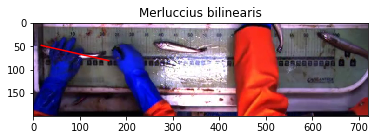

In [66]:
import ipywidgets as widgets
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
w = widgets.IntSlider(min=0, max=len(annotations))

@debounce(0.2)
def value_changed(change):
    clear_output()
    display(w)
    annotation=annotations.iloc[change['new']]
    print(annotation)
    img_path=os.path.relpath(annotation['img'], '/data')
    img = plt.imread(img_path)
    fig,axes=plt.subplots(1,1)
    axes.set_title(annotation['species_name'])
    axes.imshow(img)
    x=np.array([annotation.x1, annotation.x2])
    y=np.array([annotation.y1, annotation.y2])
    axes.plot(x,y, color='red')
    plt.show()


display(w)
w.observe(value_changed, 'value')